In [1]:
using Distributions
using Random
using LinearAlgebra
using PyPlot
using DataFrames
using CSV
using Turing
using MCMCChains
using Statistics
using Pkg

In [2]:
;julia --version

julia version 1.5.2


In [3]:
# artificial data
function create_dataset(N, D, mu_x, lambda_x, Mu_w, Lambda_w, lambda_y)
    Random.seed!(1)
    X = ones(N, D)
    X_test = ones(N, D)
    for i in 1 : N
        for j in 1 : D
            X[i, j] = rand(Normal(mu_x, lambda_x))
            X_test[i, j] = rand(Normal(mu_x, lambda_x))
        end
    end

    W = rand(MvNormal(Mu_w, Lambda_w))
    Y = ones(N)
    Y_test = ones(N)
    for i in 1 : N
        Y[i] = rand(Normal(dot(W, X[i, :]), lambda_y))
        Y_test[i] = rand(Normal(dot(W, X_test[i, :]), lambda_y))
    end
    
    return X, W, Y, X_test, Y_test
end

create_dataset (generic function with 1 method)

In [4]:
function generate_missing(X_raw, miss_rate)
    Random.seed!(1)
    
    X = copy(X_raw)
    X_replaced = []
    for i in 1:size(X)[1]
        for j in 1:size(X)[2]
            if rand() < miss_rate
                push!(X_replaced, X[i,j])
                X[i,j] = NaN
            end
        end
    end
    return X, X_replaced
end
        

generate_missing (generic function with 1 method)

In [5]:
# Parameters for the datasets
N = 30
D = 2
mu_x = 0
lambda_x = 1
Mu_w = ones(D)
Lambda_w = I
lambda_y = 1
miss_rate = 0.5

X_raw, W, Y, X_test, Y_test = create_dataset(N, D, mu_x, lambda_x, Mu_w, Lambda_w, lambda_y)
X, X_replaced = generate_missing(X_raw, miss_rate)

# remove a row if it contains nan
not_nan_idx = vec(.!any(isnan.(X), dims=2))
X_red = X[not_nan_idx, :]
Y_red = Y[not_nan_idx]

5-element Array{Float64,1}:
 -0.6663291550362418
 -0.1126536623502542
 -0.5402299893464024
  0.7231824033951142
  0.8124369342832805

In [6]:
function rmse(X_test, Y_test, W)
    (sum((Y_test - X_test*W).^2)/size(Y_test)[1])^0.5
end

rmse (generic function with 1 method)

In [7]:
function show_contour(X, W, title, margin_rate = 0.15)
    x_max = minimum(X[:, :])
    x_min = maximum(X[:, :])
    margin = margin_rate*(x_max - x_min)
    x = range(x_min - margin, x_max + margin, length=30)
    z = rand(size(x,1), size(x,1))
    X = vcat.(x, x')

    for i in 1 : size(x,1), j in 1 : size(x,1)
        z[i, j] = dot(W, X'[i,j])
    end

    PyPlot.title("$title")
    CS = contour(x, x, z)
    clabel(CS, inline=1, fontsize=10)
end

show_contour (generic function with 2 methods)

In [8]:
@model function linear_regression_with_miss(x1, x1_miss, x2, x2_miss, y, N1, N2, N3, N4)
    # hypter paramteters
    mu_x = 0
    lambda_x = 1.5
    lambda_w = 100
    lambda_y = 1
    
    nfeatures = 2
    W ~ MvNormal(nfeatures, lambda_w)
    
    # no missing
    for i in 1:N1
        mu = x1[i] * W[1] + x2[i] * W[2] 
        y[i] ~ Normal(mu, lambda_y)
    end
    
    # only x1 is missed
    for i in N1+1:N1+N2
        x1_miss[i-N1] ~ Normal(mu_x, lambda_x)
        mu = x1_miss[i-N1] * W[1] + x2[i] * W[2] 
        y[i] ~ Normal(mu, lambda_y)  
    end
    
    # only x2 is missed
    for i in N1+N2+1:N1+N2+N3
        x2_miss[i-N1-N2] ~ Normal(mu_x, lambda_x)
        mu = x1[i-N2] * W[1] + x2_miss[i-N1-N2] * W[2] 
        y[i] ~ Normal(mu, lambda_y)  
    end
    
    # both x1 and x2 are missed
    for i in N1+N2+N3+1:N1+N2+N3+N4
        x1_miss[i-N1-N3] ~ Normal(mu_x, lambda_x)
        x2_miss[i-N1-N2] ~ Normal(mu_x, lambda_x)
        mu = x1_miss[i-N1-N3] * W[1] + x2_miss[i-N1-N2] * W[2]
        y[i] ~ Normal(mu, lambda_y)  
    end
end

linear_regression_with_miss (generic function with 1 method)

In [9]:
function run_smaple(X, Y)
    id1 = .~isnan.(X[:,1]) .& .~isnan.(X[:,2])
    id2 = isnan.(X[:,1]) .& .~isnan.(X[:,2])
    id3 = .~isnan.(X[:,1]) .& isnan.(X[:,2])
    id4 = isnan.(X[:,1]) .& isnan.(X[:,2])
    
    x1 = vcat(X[id1,:], X[id3,:])[:,1]
    x1_miss = fill(missing, size(vcat(X[id2,:], X[id4,:])[:,1], 1))
    x2 = vcat(X[id1,:], X[id2,:])[:,2]
    x2_miss = fill(missing, size(vcat(X[id3,:], X[id4,:])[:,2], 1))
    y = vcat(Y[id1], Y[id2], Y[id3], Y[id4])
    
    N1 = sum(id1)
    N2 = sum(id2)
    N3 = sum(id3)
    N4 = sum(id4)
    model = linear_regression_with_miss(x1, x1_miss, x2, x2_miss, y, N1, N2, N3, N4)
    chain = sample(model, NUTS(), 3000)
end

run_smaple (generic function with 1 method)

In [10]:
chain1 = run_smaple(X_red, Y_red)
W_chain = chain1[:,1:2,:]
Mu_w_red = summarize(W_chain, mean).nt[:mean]
###################################

chain2 = run_smaple(X, Y)
W_chain = chain2[:,1:2,:]
X_chain = chain2[:,3:end,:]
Mu_w = summarize(W_chain, mean).nt[:mean]
X_est = copy(X)
X_est[isnan.(X)] = summarize(X_chain, mean).nt[:mean]
X_std = 0*copy(X)
X_std[isnan.(X)] = summarize(X_chain, std).nt[:std];
###########################

chain3 = run_smaple(X_raw, Y)
W_chain = chain3[:,1:2,:]
Mu_w_raw = summarize(W_chain, mean).nt[:mean];

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/teppei/.julia/packages/Turing/UsQlw/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/teppei/.julia/packages/Turing/UsQlw/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:19
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/teppei/.julia/packages/Turing/UsQlw/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [11]:
chain1

Chains MCMC chain (2000×14×1 Array{Float64,3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
parameters        = W[1], W[2]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
        W[1]    0.8527    0.9471     0.0212    0.0498   507.8192    1.0016  
        W[2]   -0.7658    0.7007     0.0157    0.0368   502.8375    1.0012  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
        W

In [12]:
chain2

Chains MCMC chain (2000×48×1 Array{Float64,3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
parameters        = W[1], W[2], x1_miss[1], x1_miss[2], x1_miss[3], x1_miss[4], x1_miss[5], x1_miss[6], x1_miss[7], x1_miss[8], x1_miss[9], x1_miss[10], x1_miss[11], x1_miss[12], x1_miss[13], x1_miss[14], x1_miss[15], x1_miss[16], x1_miss[17], x1_miss[18], x1_miss[19], x1_miss[20], x1_miss[21], x1_miss[22], x2_miss[1], x2_miss[2], x2_miss[3], x2_miss[4], x2_miss[5], x2_miss[6], x2_miss[7], x2_miss[8], x2_miss[9], x2_miss[10], x2_miss[11], x2_miss[12]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
   parameters      mean       std   naive_se      mcse         ess      rhat  
       Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                  

In [13]:
chain3

Chains MCMC chain (2000×14×1 Array{Float64,3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
parameters        = W[1], W[2]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
        W[1]   -0.1699    0.1996     0.0045    0.0052   1757.2676    0.9997  
        W[2]   -0.4990    0.1774     0.0040    0.0044   1666.6874    1.0016  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
    

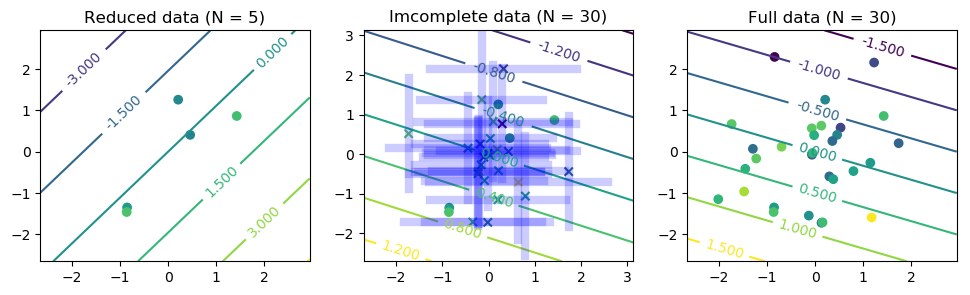

PyObject <matplotlib.collections.PathCollection object at 0x7fd5aeefda90>

In [14]:
figure("result", figsize=(16,3))
subplot(1,4,1)
show_contour(X_raw, Mu_w_red, "Reduced data (N = $(size(X_red,1)))")
scatter(X_red[:, 1], X_red[:, 2], c=Y_red, vmin=minimum(Y), vmax=maximum(Y))

idx_nan = vec(any(isnan.(X), dims=2))
subplot(1,4,2)
show_contour(X_est, Mu_w, "Imcomplete data (N = $N)", 0.25)
scatter(X_red[:, 1], X_red[:, 2], c=Y_red, vmin=minimum(Y), vmax=maximum(Y))
scatter(X_est[idx_nan, 1], X_est[idx_nan, 2], c=Y[idx_nan], marker="x", vmin=minimum(Y), vmax=maximum(Y))

for i in findall(idx_nan)
    plot([X_est[i,1] - X_std[i,1], X_est[i,1] + X_std[i,1]], [X_est[i,2], X_est[i,2]], "b", alpha=0.2, linewidth=6)
    plot([X_est[i,1], X_est[i,1]], [X_est[i,2]-X_std[i,2], X_est[i,2] + X_std[i,2]], "b", alpha=0.2, linewidth=6)
end

subplot(1,4,3)
show_contour(X_raw, Mu_w_raw, "Full data (N = $N)")
scatter(X_raw[:, 1], X_raw[:, 2], c=Y)

In [15]:
rmse(X_test, Y_test, Mu_w_red), rmse(X_test, Y_test, Mu_w), rmse(X_test, Y_test, Mu_w_raw)

(1.502013477660365, 0.9667536311273563, 0.9977174995565266)